# Bandit Simulation

In [ ]:
import torch
print(torch.cuda.is_available())    
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 4060 Laptop GPU


/home/ice/Exoplanets/bandits_algorithms/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


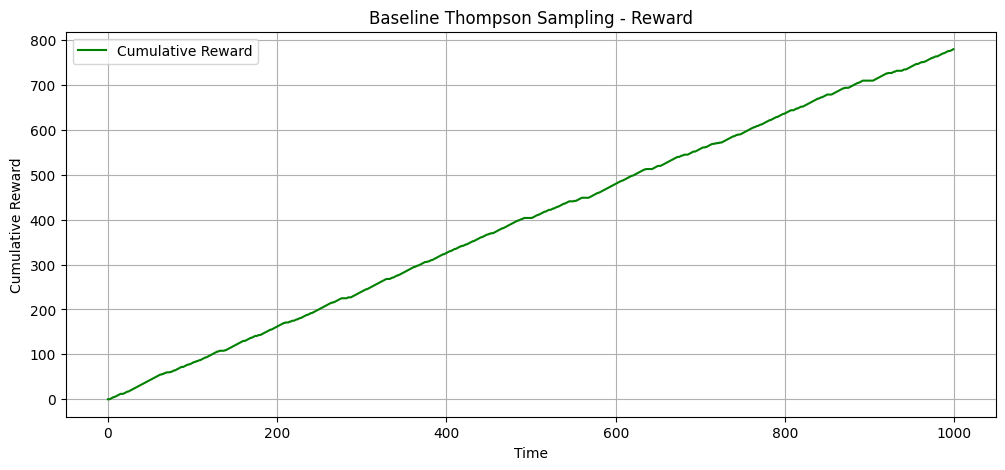

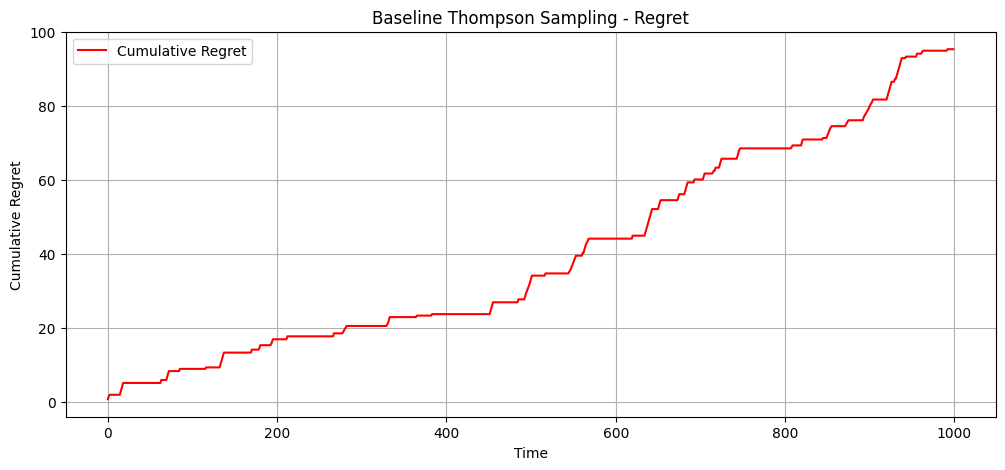

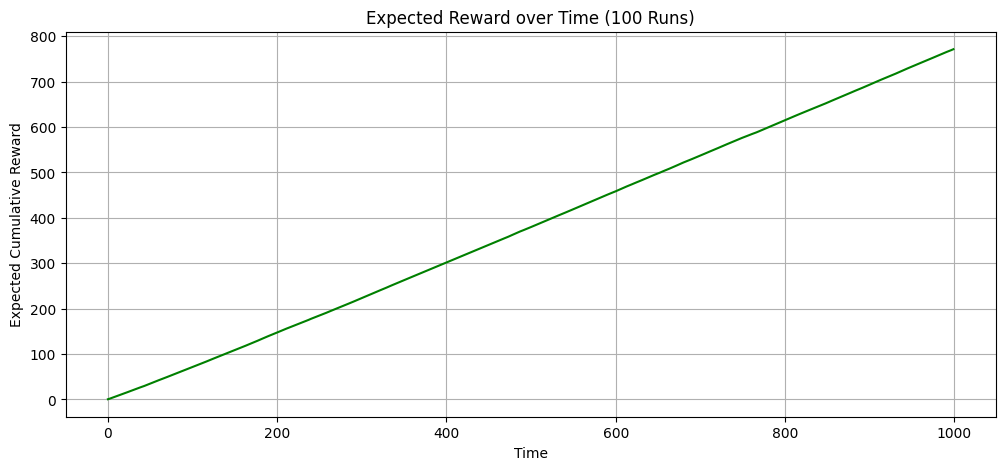

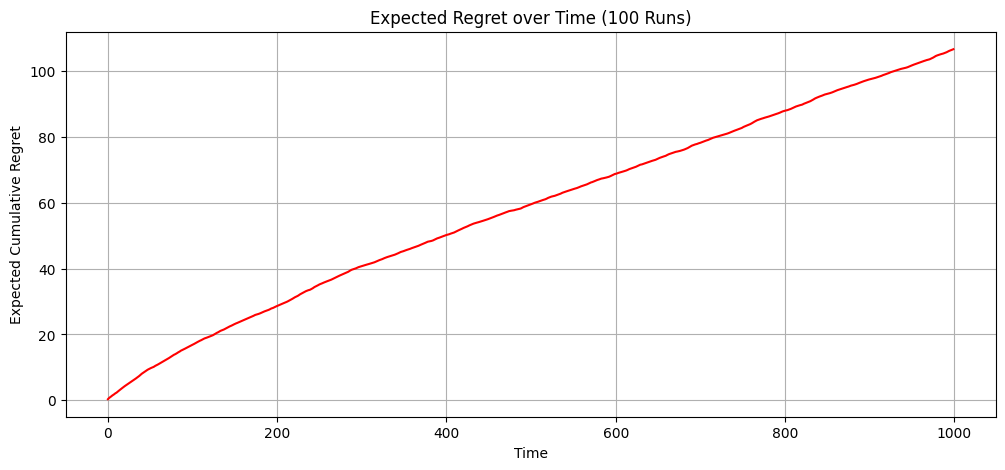

In [ ]:
# Global State Bandit Simulation - Fastest Python Version with GPU Support

# Cell 1: Imports and Setup
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import pyro.poutine as poutine
import pandas as pd
from pyro.infer.autoguide import AutoDelta
from pyro.infer import config_enumerate
import pyro
import pyro.distributions as dist
import torch

# GPU available?
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Cell 2: Parameters
K = 3
N = 1000

theta = torch.tensor([
    [0.1, 0.9],
    [0.4, 0.6],
    [0.9, 0.1]
], device=device)

pi_indiv = torch.tensor([
    [[0.9, 0.1], [0.1, 0.9]],
    [[0.85, 0.15], [0.2, 0.8]],
    [[0.95, 0.05], [0.3, 0.7]]
], device=device)

# Cell 3: Simulate Ground Truth Data
def simulate_bandit_data(K, N, theta, pi_indiv):
    z = torch.zeros((K, N), dtype=torch.int64, device=device)
    y = torch.zeros((K, N), dtype=torch.int64, device=device)

    for i in range(K):
        z[i, 0] = torch.bernoulli(torch.tensor(0.5, device=device)).long()
        y[i, 0] = torch.bernoulli(theta[i, z[i, 0]])
        for t in range(1, N):
            prob = pi_indiv[i, z[i, t-1], 1]
            z[i, t] = torch.bernoulli(prob).long()
            y[i, t] = torch.bernoulli(theta[i, z[i, t]])
    return y, z

# Cell 4: Generate and Store Data
y_true, z_true = simulate_bandit_data(K, N, theta, pi_indiv)

# Cell 5: Baseline Thompson Sampling
def baseline_thompson(K, N, y_true, z_true, theta):
    rewards = torch.zeros(K, device=device)
    counts = torch.ones(K, device=device)
    cum_regret = torch.zeros(N, device=device)
    cum_reward = torch.zeros(N, device=device)
    selected = torch.zeros(N, dtype=torch.int64, device=device)

    for t in range(N):
        samples = torch.distributions.Beta(rewards + 1, counts - rewards + 1).sample()
        a_t = torch.argmax(samples).item()

        r = y_true[a_t, t].float()
        rewards[a_t] += r
        counts[a_t] += 1

        oracle = torch.argmax(torch.tensor([theta[k, z_true[k, t]] for k in range(K)], device=device))
        opt_reward = theta[oracle, z_true[oracle, t]]
        regret = opt_reward - theta[a_t, z_true[a_t, t]]

        cum_reward[t] = rewards.sum()
        cum_regret[t] = cum_regret[t - 1] + regret if t > 0 else regret
        selected[t] = a_t

    return cum_reward.cpu().numpy(), cum_regret.cpu().numpy(), selected.cpu().numpy()

# Cell 6: Run Baseline Thompson
c_reward, c_regret, chosen = baseline_thompson(K, N, y_true, z_true, theta)

# Cell 7: Plot Results
plt.figure(figsize=(12, 5))
plt.plot(c_reward, label='Cumulative Reward', color='green')
plt.title('Baseline Thompson Sampling - Reward')
plt.xlabel('Time')
plt.ylabel('Cumulative Reward')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(c_regret, label='Cumulative Regret', color='red')
plt.title('Baseline Thompson Sampling - Regret')
plt.xlabel('Time')
plt.ylabel('Cumulative Regret')
plt.legend()
plt.grid(True)
plt.show()

# Cell 8: Expected Regret (Optional Multiple Runs)
def run_expectation(K, N, theta, pi_indiv, runs=100):
    rewards_all = []
    regrets_all = []
    for _ in range(runs):
        y, z = simulate_bandit_data(K, N, theta, pi_indiv)
        r, rg, _ = baseline_thompson(K, N, y, z, theta)
        rewards_all.append(r)
        regrets_all.append(rg)
    return np.mean(rewards_all, axis=0), np.mean(regrets_all, axis=0)

# Cell 9: Run and Plot Expectation
exp_reward, exp_regret = run_expectation(K, N, theta, pi_indiv, runs=100)

plt.figure(figsize=(12, 5))
plt.plot(exp_reward, label='Expected Reward', color='green')
plt.title('Expected Reward over Time (100 Runs)')
plt.xlabel('Time')
plt.ylabel('Expected Cumulative Reward')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(exp_regret, label='Expected Regret', color='red')
plt.title('Expected Regret over Time (100 Runs)')
plt.xlabel('Time')
plt.ylabel('Expected Cumulative Regret')
plt.grid(True)
plt.show()

### Pyro model for single arm with discrete latent state

In [11]:
from pyro.infer import config_enumerate

@config_enumerate
def hmm_arm_model(y_obs):
    theta0 = pyro.sample("theta0", dist.Beta(1., 1.))
    theta1 = pyro.sample("theta1", dist.Beta(1., 1.))
    pi0 = pyro.sample("pi0", dist.Beta(1., 1.))
    pi1 = pyro.sample("pi1", dist.Beta(1., 1.))

    z_prev = pyro.sample("z_init", dist.Bernoulli(0.5))

    for t in range(N):
        z_t = pyro.sample(f"z_{t}", dist.Bernoulli(torch.where(z_prev == 1, pi1, pi0)))
        p = torch.where(z_t == 1, theta1, theta0)
        pyro.sample(f"y_{t}", dist.Bernoulli(p), obs=y_obs[t])
        z_prev = z_t

### Thompson Sampling with posterior samples from Pyro

In [12]:
def thompson_sampling_pyro(K, N, theta, y_true, batch_size=10):
    posterior_samples = [None] * K
    observed_rewards = [[] for _ in range(K)]
    selected_arms = []
    regrets = []

    for t in range(N):
        sampled_probs = []
        for k in range(K):
            if posterior_samples[k] is not None:
                sample = posterior_samples[k]
                theta0 = sample["theta0"]
                theta1 = sample["theta1"]
                pi0 = sample["pi0"]
                pi1 = sample["pi1"]
                z_prev = sample.get("z_prev", 0.0)
                z_t = torch.bernoulli(pi1 if z_prev == 1 else pi0)
                prob = (1 - z_t) * theta0 + z_t * theta1
            else:
                prob = torch.rand(1)
            sampled_probs.append(prob)

        a_t = torch.argmax(torch.tensor(sampled_probs)).item()
        selected_arms.append(a_t)

        reward = y_true[a_t, t].item()
        observed_rewards[a_t].append(reward)

        opt_arm = torch.argmax(torch.tensor([theta[i, z_true[i, t]] for i in range(K)])).item()
        opt_reward = theta[opt_arm, z_true[opt_arm, t]]
        actual_reward = theta[a_t, z_true[a_t, t]]
        regret = (opt_reward - actual_reward).item()
        regrets.append(regret)

        if len(observed_rewards[a_t]) % batch_size == 0 and len(observed_rewards[a_t]) >= 5:
            y_obs = torch.tensor(observed_rewards[a_t], dtype=torch.float32)
            nuts_kernel = NUTS(hmm_arm_model, max_tree_depth=5)  # reduce tree depth for speed
            mcmc = MCMC(nuts_kernel, num_samples=25, warmup_steps=50, disable_progbar=False)
            mcmc.run(y_obs)
            posterior_samples[a_t] = {k: v[0].detach() for k, v in mcmc.get_samples().items()}
            posterior_samples[a_t]["z_prev"] = posterior_samples[a_t].get(f"z_{len(y_obs)-1}", torch.tensor(0.))

    return np.cumsum([y_true[a, t].item() for t, a in enumerate(selected_arms)]), np.cumsum(regrets)

# Cell 7: Run Poor Model Thompson Sampling
poor_reward, poor_regret = thompson_sampling_pyro(K, N, theta, y_true, batch_size=10)

# Cell 8: Plot
plt.figure(figsize=(12, 5))
plt.plot(poor_reward, label='Cumulative Reward', color='blue')
plt.title('Poor Model Thompson Sampling (Pyro - Discrete Latent State)')
plt.xlabel('Time')
plt.ylabel('Cumulative Reward')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(poor_regret, label='Cumulative Regret', color='orange')
plt.title('Poor Model Thompson Sampling (Pyro - Discrete Latent State)')
plt.xlabel('Time')
plt.ylabel('Cumulative Regret')
plt.legend()
plt.grid(True)
plt.show()

Warmup:   0%|          | 0/75 [00:00, ?it/s]

IndexError: index 10 is out of bounds for dimension 0 with size 10